## Import thư viện

In [227]:
# Thư viện đọc file và chuyển kiểu
import pandas as pd
import numpy as np

# Đổi kiểu dữ liệu datetime
import datetime as dt

# Import các thư viện train
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import sklearn để tính toán các giá trị cũng như scaled dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

# Thư viện trực quan hóa dữ liệu
import matplotlib.pyplot as plt
%matplotlib inline

## Đọc dữ liệu từ file

In [228]:
df = pd.read_csv('../../Dataset/CTLT.csv')
df = df.dropna() # Drop missing values
#df = df.reset_index(drop=True) # Reset the index

In [122]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1079,2023-04-17,46.009998,49.860001,42.529999,45.430000,45.430000,14629300
1080,2023-04-18,45.200001,45.375000,41.509998,42.080002,42.080002,10057000
1081,2023-04-19,41.419998,43.669998,41.330002,43.070000,43.070000,6744900
1082,2023-04-20,42.660000,44.410000,42.259998,44.400002,44.400002,3464300


In [229]:
# Chuyển đổi kiểu dữ liệu của cột Date sang datetime64
df['Date'] = pd.to_datetime(df['Date'])

# Đặt cột Date làm index của DataFrame
df.set_index('Date', inplace=True)

## Phân tích dữ liệu

In [124]:
# Các độ đo về các thuộc tính của tập dữ liệu
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1.084000e+03
mean,81.386891,82.582040,80.080622,81.360083,81.360083,1.316687e+06
std,29.623591,29.926995,29.218822,29.553762,29.553762,1.607532e+06
min,30.049999,30.660000,29.290001,29.840000,29.840000,2.197000e+05
25%,52.202500,53.042000,51.707500,52.247501,52.247501,7.046750e+05
50%,83.495002,84.510002,82.259998,83.505001,83.505001,9.811000e+05
75%,106.260000,108.073750,104.765001,106.450002,106.450002,1.423700e+06
max,142.639999,142.639999,140.779999,142.350006,142.350006,3.083880e+07


In [125]:
print("Information of Close Price")
print("Number Of Lines: ", len(df.Close))
print(f"Maximum: {max(df.Close)}")
print(f"Minimum: {min(df.Close)}")
print(f"Average: {st.mean(df.Close)}")
print(f"Median: {st.median(df.Close)}")

freq_table = co.Counter(df.Close)
max_freq = max(freq_table.values())
mode_values = [k for k, v in freq_table.items() if v == max_freq]
print("Mode: ", mode_values)

quantile = [np.percentile(df.Close, 25), np.percentile(df.Close, 50), np.percentile(df.Close, 75)]
print("Quantile: ", quantile)

print("Variance: ", st.variance(df.Close))
print("Standard deviation: ", st.stdev(df.Close))
print("Coefficient of Variation: ", st.stdev(df.Close))
print("Coefficient of Skewness: ", df.Close.skew())
print("Coefficient of Kurtosis: ", df.Close.kurtosis())

Information of Close Price
Number Of Lines:  1084
Maximum: 142.350006
Minimum: 29.84
Average: 81.36008313284132
Median: 83.505001
Mode:  [51.599998, 48.630001, 109.610001]
Quantile:  [52.2475005, 83.505001, 106.45000225000001]
Variance:  873.4248394348966
Standard deviation:  29.553761849126698
Coefficient of Variation:  29.553761849126698
Coefficient of Skewness:  0.10759095239193849
Coefficient of Kurtosis:  -1.317622277921274


### Trực quan hóa dữ liệu

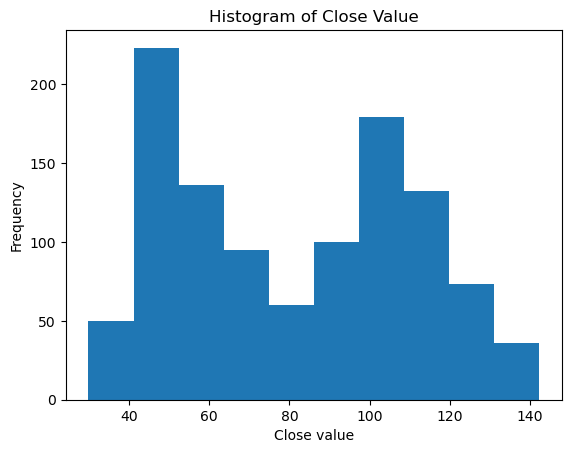

In [126]:
# Vẽ biểu đồ Histogram
plt.hist(df['Close'])

# Thiết lập label và title
plt.xlabel('Close value')
plt.ylabel('Frequency')
plt.title('Histogram of Close Value')

# Hiển thị biểu đồ histogram
plt.show()

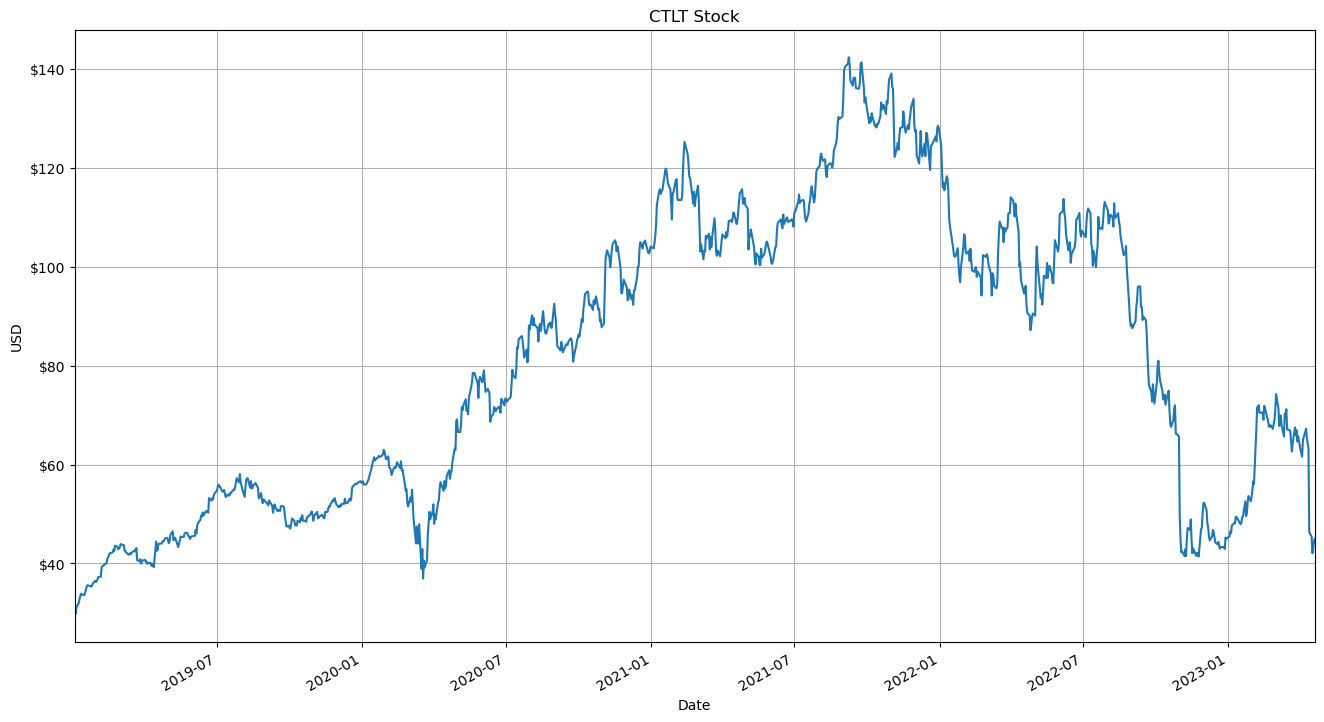

In [127]:


# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')
title = 'CTLT Stock'
ylabel = 'USD'
xlabel = 'Date'

# Vẽ biểu đồ theo index của DataFrame
ax = df['Close'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Hiển thị biểu đồ
plt.show()


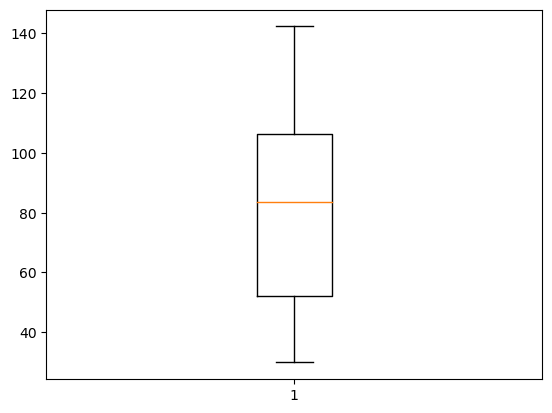

In [128]:
plt.boxplot(df.Close)
plt.show()

## Xây dựng mô hình

In [230]:
#  Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df_scaled=scaler.fit_transform(np.array(df).reshape(-1,1))

### Chia tập train, test, validation

In [231]:
# Chia dữ liệu thành tập train, validation và test theo tỉ lệ 7:2:1
train_size = int(len(df_scaled) * 0.7)
val_size = int(len(df_scaled) * 0.2)
test_size = len(df_scaled) - train_size - val_size

train_data = df_scaled[0 : train_size, :]
val_data = df_scaled[train_size : train_size + val_size, :]
test_data = df_scaled[train_size + val_size : len(df_scaled), :]

In [232]:
X = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

In [233]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [234]:
# Thêm dữ liệu cho tập train, validation và test
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)


In [204]:
# X_train = X_train.reshape(X_train.shape[0], 30, 1)
# X_test = X_test.reshape(X_test.shape[0], 30, 1)
# X_val = X_val.reshape(X_val.shape[0], 30, 1)

In [236]:
# 7. Reshape input to be [samples, features] 

X_train = X_train.reshape(X_train.shape[0], 4)
X_test = X_test.reshape(X_test.shape[0], 4)
X_val = X_val.reshape(X_val.shape[0], 4)


ValueError: cannot reshape array of size 135630 into shape (4521,4)

### Xây dựng mô hình Deep Feedforward Neural Network

In [237]:
from keras.layers import Reshape
model.add(Reshape((30, 1), input_shape=(30,)))

In [238]:
# Tạo một đối tượng Sequential model
model = Sequential()

# Xây dựng 3 layer: 1 input layer, 2 hidden layer, 1 output layer

# input layer với 4 đầu vào (Open, High, Low, Volume)
# hidden layer thứ nhất với 128 node, hàm kích hoạt ReLU

model.add(Dense(128, input_dim=4, activation='relu'))

# hidden layer thứ hai với 64 node, hàm kích hoạt ReLU
model.add(Dense(64, activation='relu'))

# hidden layer thứ ba với 32 node, hàm kích hoạt ReLU
model.add(Dense(32, activation='relu'))


# output layer với 1 node và hàm kích hoạt là linear
model.add(Dense(1, activation='linear'))

# Loss function và optimizer
model.compile(loss='mean_squared_error', optimizer='adam')  

### Biên dịch mô hình

In [239]:
model.compile(loss='mean_squared_error', optimizer='adam')

### Huấn luyện mô hình

In [241]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1)

Epoch 1/100


ValueError: in user code:

    File "d:\Sofware\Anaconda\envs\user_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "d:\Sofware\Anaconda\envs\user_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Sofware\Anaconda\envs\user_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "d:\Sofware\Anaconda\envs\user_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "d:\Sofware\Anaconda\envs\user_env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Sofware\Anaconda\envs\user_env\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 4), found shape=(None, 30)


### Vẽ đồ thị loss trên tập train và tập validation

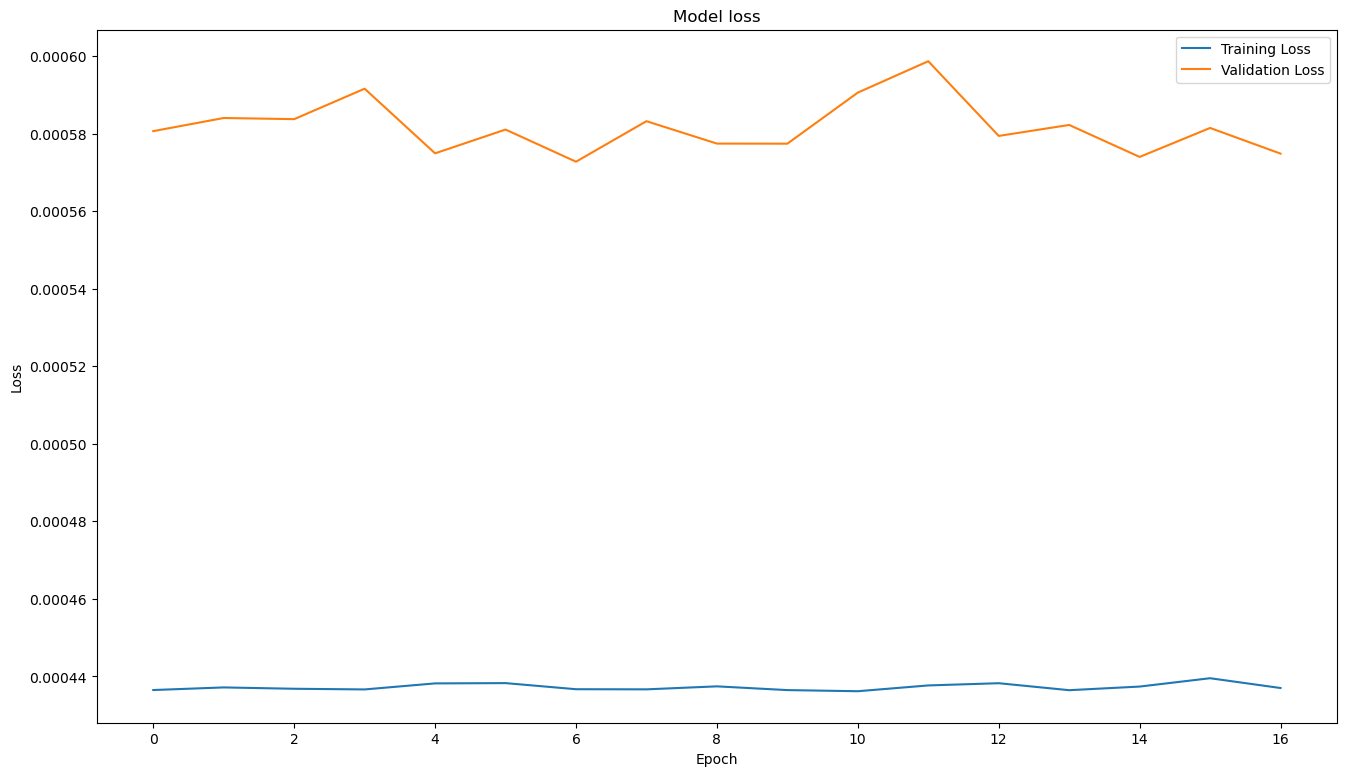

In [226]:
plt.figure(figsize=(16, 9))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

<h2>Dự đoán CLose Price trên tập test và validation

In [216]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

40/40 [==============================] - 0s 2ms/step


In [218]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

ValueError: Found array with dim 3. None expected <= 2.

## Đánh giá mô hình

In [220]:
# Dự đoán giá trên tập validation
y_val_pred = model.predict(X_val)

#Chuyển về giá trị ban đầu (dùng scaler.inverse_transform)

# Tính các độ đo
mae = mean_absolute_error(y_val, y_val_pred)
mape = mean_absolute_percentage_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)

print("Mean Absolute Error (MAE): {:.2f} USD".format(mae))
print("Mean Absolute Percentage Error (MAPE): {:.2f} %".format(mape * 100))
print("Root Mean Square Error (RMSE): {:.2f} USD".format(rmse))


40/40 [==============================] - 0s 2ms/step


ValueError: Found array with dim 3. None expected <= 2.

## Trực quan hóa kết quả dự đoán của mô hình so với giá trị thực tế

20/20 [==============================] - 0s 2ms/step


ValueError: x and y can be no greater than 2D, but have shapes (621,) and (621, 30, 1)

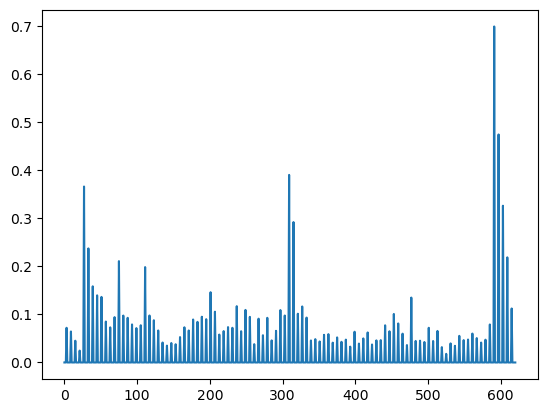

In [221]:
y_pred = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

20/20 [==============================] - 0s 2ms/step


ValueError: x and y must have same first dimension, but have shapes (0,) and (621,)

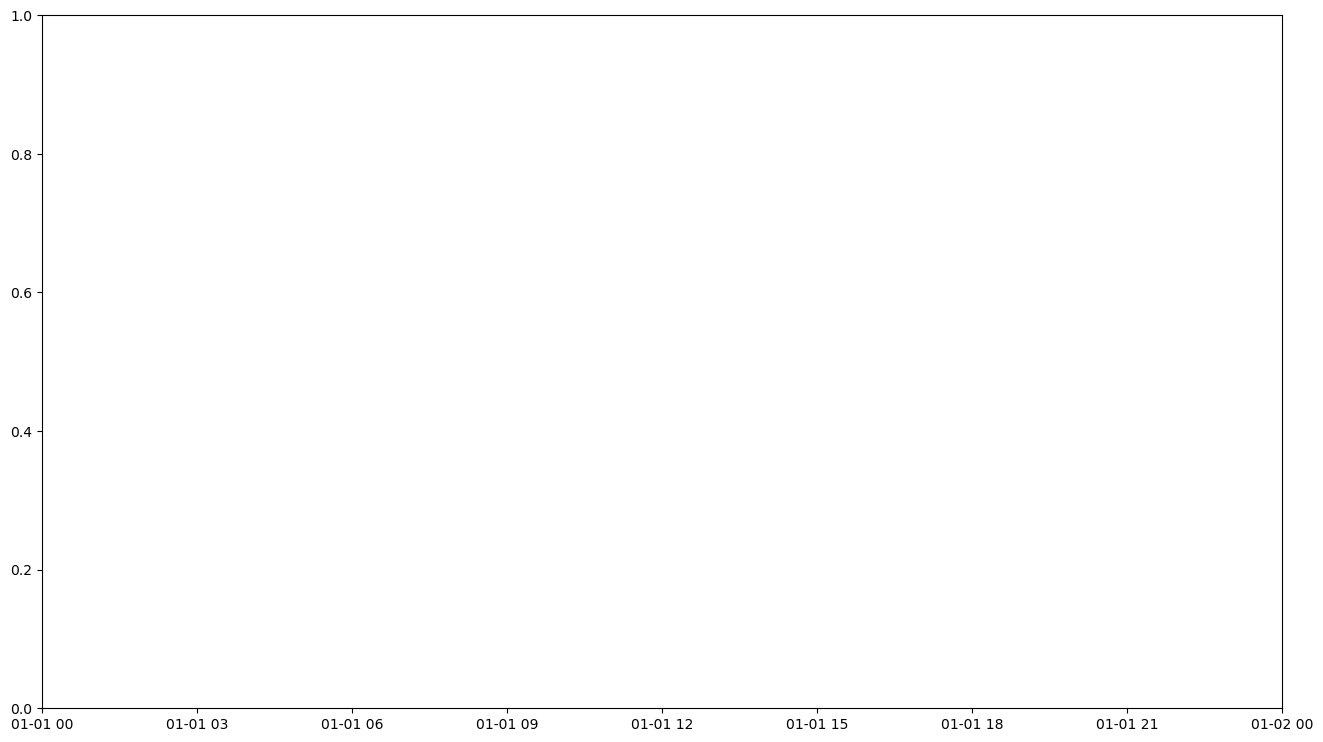

In [222]:
y_pred = model.predict(X_test)

# # Chuyển đổi kiểu dữ liệu của cột Date sang datetime64
# df['Date'] = pd.to_datetime(df['Date'])

# # Đặt cột Date làm index của DataFrame
# df.set_index('Date', inplace=True)

fig, ax = plt.subplots(figsize=(16, 9))

# ax.plot(df.index[train_size+val_size:], df['Close'].values[train_size+val_size:], label='Actual')
# ax.plot(df.index[train_size+val_size:], y_pred, label='Predicted')

ax.plot(df.index[train_size+val_size:], y_test, label='Actual')
ax.plot(df.index[train_size+val_size:], y_pred, label='Predicted')

formatter = ticker.StrMethodFormatter('${x:,.0f}')
ax.set_title('Comparison between Actual and Predicted Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')

ax.autoscale(axis='x', tight=True)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

ax.legend()
plt.show()

 ### Lưu mô hình

In [ ]:
# Lưu lại model tốt nhất
model.save('DFNN_Model.h5')

#best_model = ModelCheckpoint(DFNN_Model_Trained, monitor='loss', verbose=2, save_best_only=True, mode='auto')

## Sử dụng mô hình Deep Feedforward Neural Network để dự đoán giá cổ phiếu trong tương lai

### Dự đoán trong 30 ngày tới

In [ ]:
# Chuẩn bị dữ liệu'
df = pd.read_csv('./Data/CTLT.csv')

# start_date = '2023-02-07'

# filtered_df = df[df['Date'] >= start_date]
# df_pred = filtered_df[['Open', 'High', 'Low', 'Volume']].values

# scaler = StandardScaler()
# df_pred = scaler.fit_transform(df_pred.reshape(-1, 1))
# X_pred = np.array([df_pred[i:i+30] for i in range(len(df_pred)-30)])
# X_pred = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1]))
# X_pred = np.expand_dims(X_pred, axis=2)

# Lấy dữ liệu gần nhất 30 ngày
df_pred = df[['Open', 'High', 'Low', 'Volume']].tail(30).values

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_pred = scaler.fit_transform(df_pred)


Tải mô hình đã lưu

In [ ]:
# Tải mô hình đã được lưu
model_DFNN = load_model('./Trained/')

## Dự đoán giá 30 ngày tiếp theo

In [ ]:
# Dự đoán giá trong 30 ngày tiếp theo

#Chuyển kích thước X_pred cho phù hợp 
#X_pred = df_pred.reshape(-1, X_pred.shape[0], X_pred.shape[1])
#X_pred = X_pred.reshape(30, 4)

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)



In [ ]:
x_next_30_days

array([[251],
       [252],
       [253],
       [254],
       [255],
       [256],
       [257],
       [258],
       [259],
       [260],
       [261],
       [262],
       [263],
       [264],
       [265],
       [266],
       [267],
       [268],
       [269],
       [270],
       [271],
       [272],
       [273],
       [274],
       [275],
       [276],
       [277],
       [278],
       [279],
       [280]])

In [ ]:
# # Predict the closing prices for the next 30 days
# y_next_30_days = model.predict(x_next_30_days)

# # Print the predicted closing prices for the next 30 days
# print('Predicted closing prices for the next 30 days:')
# print(y_next_30_days)



In [ ]:
#y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()

### Trực quan hóa dữ liệu

In [ ]:
#date_range = pd.date_range(last_date, periods=30, freq='D')[1:]

# Lấy dữ liệu thực tế
df_actual = pd.read_csv('./Data/CTLT.csv', index_col='Date', parse_dates=['Date'])
df_actual = df_actual[:-30]
y_actual = df_actual['Close'].values

# Tạo biểu đồ
x_actual = np.arange(len(y_actual))
X_pred_original = np.arange(len(y_actual), len(y_actual) + len(y_pred))

In [ ]:
x_actual, X_pred_original

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

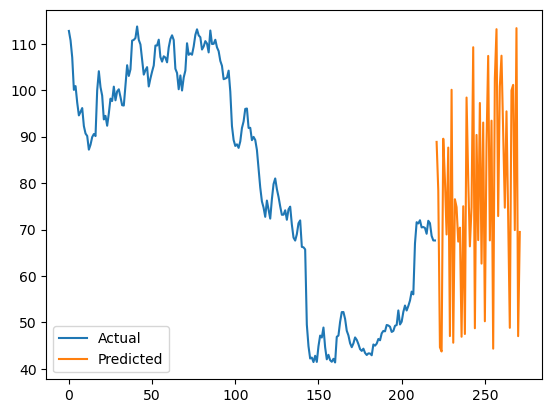

In [ ]:
plt.plot(x_actual, y_actual, label='Actual')
plt.plot(X_pred_original, y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
x_actual, y_actual

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [ ]:
X_pred, y_pred

(array([[-0.15678992, -0.03755869,  0.19875548, -0.30404931],
        [ 0.46637966,  0.07445709,  0.43908929, -0.95404762],
        [-0.15678992,  0.10202274,  0.18688831,  0.42691015],
        [ 0.14951413,  0.32535882,  0.5392268 , -0.6696012 ],
        [ 0.48046009,  0.94127111,  0.84706072, -0.191483  ],
        [ 1.51907548,  2.0736407 ,  1.97083825,  0.36009194],
        [ 2.47319137,  1.98989129,  2.04130728, -0.75518046],
        [ 1.47682573,  1.13494325,  0.69166115, -0.37389815],
        [ 0.20232535,  0.66384677,  0.62824077, -0.34994173],
        [ 0.96984321,  1.24661007,  1.33292072,  1.02279004],
        [ 0.79732597,  0.41608636,  0.46876073,  0.4703492 ],
        [-0.03004385, -0.40396649, -0.53633398,  2.07312034],
        [ 0.06149603,  0.97267601,  0.45021543,  1.19423719],
        [ 0.74099579,  0.59056577,  0.66903835,  0.24853584],
        [ 0.78324272,  0.94999299,  0.95090781, -0.8085773 ],
        [ 0.67410098,  0.20671143,  0.36120406,  3.58973495],
        

ValueError: x and y must have same first dimension, but have shapes (30,) and (51, 1)

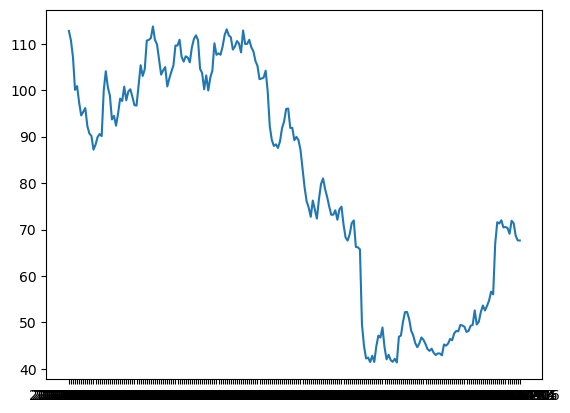

In [ ]:

# Tạo list các ngày
dates = df['Date'].tolist()
dates = df['Date'].tolist()[-221:]
# Vẽ đồ thị
plt.plot(dates, y_actual, label='Actual')
plt.plot(dates[-30:], y_pred, label='Predicted')

# Đặt nhãn cho trục x
plt.xticks(dates[::30], rotation=45)

# Đặt tiêu đề cho đồ thị và các trục
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Hiển thị đồ thị
plt.show()

Validation RMSE: 33.97349329771458
Testing RMSE: 29.617219966379857


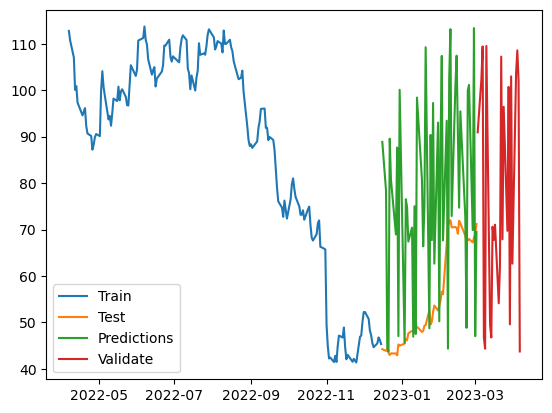

In [ ]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_val_pred - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_val_pred)
#plt.plot(last_data,y_next_30_days)
#plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.legend(['Train', 'Test', 'Predictions','Validate'])
plt.show()